In [1]:
from google.colab import files
uploaded = files.upload()

Saving api_data_aadhar_demographic_0_500000.csv to api_data_aadhar_demographic_0_500000 (2).csv
Saving api_data_aadhar_demographic_500000_1000000.csv to api_data_aadhar_demographic_500000_1000000 (2).csv
Saving api_data_aadhar_demographic_1000000_1500000.csv to api_data_aadhar_demographic_1000000_1500000 (2).csv
Saving api_data_aadhar_demographic_1500000_2000000.csv to api_data_aadhar_demographic_1500000_2000000 (2).csv
Saving api_data_aadhar_demographic_2000000_2071700.csv to api_data_aadhar_demographic_2000000_2071700 (2).csv


# Aadhaar Youth Activity Analysis - Comprehensive Notebook

In [2]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Set visualization styles
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 10


## 1. Data Loading and Initial Exploration

In [4]:
files_list = ["api_data_aadhar_demographic_0_500000.csv",
    "api_data_aadhar_demographic_500000_1000000.csv",
    "api_data_aadhar_demographic_1000000_1500000.csv",
    "api_data_aadhar_demographic_1500000_2000000.csv",
    "api_data_aadhar_demographic_2000000_2071700.csv"]
combined_df = pd.concat([pd.read_csv(file) for file in files_list], ignore_index=True)

print(f"\nDataset Shape: {combined_df.shape}")
print(f"Total Records: {combined_df.shape[0]:,}")
print(f"Total Features: {combined_df.shape[1]}")

print(combined_df.info())

print(combined_df.head(10))

print(combined_df.describe())

missing = combined_df.isnull().sum()
missing_pct = (missing / len(combined_df)) * 100
missing_df = pd.DataFrame({'Missing Count': missing, 'Percentage': missing_pct})
print(missing_df[missing_df['Missing Count'] > 0].sort_values('Missing Count', ascending=False))


Dataset Shape: (2071700, 6)
Total Records: 2,071,700
Total Features: 6
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2071700 entries, 0 to 2071699
Data columns (total 6 columns):
 #   Column         Dtype 
---  ------         ----- 
 0   date           object
 1   state          object
 2   district       object
 3   pincode        int64 
 4   demo_age_5_17  int64 
 5   demo_age_17_   int64 
dtypes: int64(3), object(3)
memory usage: 94.8+ MB
None
         date           state           district  pincode  demo_age_5_17  \
0  01-03-2025   Uttar Pradesh          Gorakhpur   273213             49   
1  01-03-2025  Andhra Pradesh           Chittoor   517132             22   
2  01-03-2025         Gujarat             Rajkot   360006             65   
3  01-03-2025  Andhra Pradesh         Srikakulam   532484             24   
4  01-03-2025       Rajasthan            Udaipur   313801             45   
5  01-03-2025       Rajasthan              Sikar   332028             28   
6  01-03-202

## 2. Data Preprocessing

In [5]:
# Convert date column
combined_df['date'] = pd.to_datetime(combined_df['date'], dayfirst=True, errors='coerce')

In [6]:
# Create youth metrics
combined_df['total_youth'] = combined_df['demo_age_5_17'] + combined_df['demo_age_17_']
combined_df['total_population'] = combined_df.filter(regex='demo_age').sum(axis=1)
combined_df['youth_population_ratio'] = combined_df['total_youth'] / combined_df['total_population']

In [7]:
# Extract temporal features
combined_df['year'] = combined_df['date'].dt.year
combined_df['month'] = combined_df['date'].dt.month
combined_df['quarter'] = combined_df['date'].dt.quarter
combined_df['year_month'] = combined_df['date'].dt.to_period('M')
combined_df['day_of_week'] = combined_df['date'].dt.dayofweek
combined_df['is_weekend'] = combined_df['day_of_week'].isin([5, 6]).astype(int)

print("\n" + "="*80)
print("PROCESSED DATASET")
print("="*80)
print(combined_df[['date', 'state', 'total_youth', 'total_population',
                    'youth_population_ratio', 'year', 'month']].head(10))


PROCESSED DATASET
        date           state  total_youth  total_population  \
0 2025-03-01   Uttar Pradesh          578               578   
1 2025-03-01  Andhra Pradesh          397               397   
2 2025-03-01         Gujarat          830               830   
3 2025-03-01  Andhra Pradesh          338               338   
4 2025-03-01       Rajasthan          830               830   
5 2025-03-01       Rajasthan          313               313   
6 2025-03-01       Karnataka          420               420   
7 2025-03-01   Uttar Pradesh          897               897   
8 2025-03-01  Andhra Pradesh         1069              1069   
9 2025-03-01     West Bengal          294               294   

   youth_population_ratio  year  month  
0                     1.0  2025      3  
1                     1.0  2025      3  
2                     1.0  2025      3  
3                     1.0  2025      3  
4                     1.0  2025      3  
5                     1.0  2025      3  


## 3. UNIVARIATE ANALYSIS

### 3.1 Youth Distribution Analysis

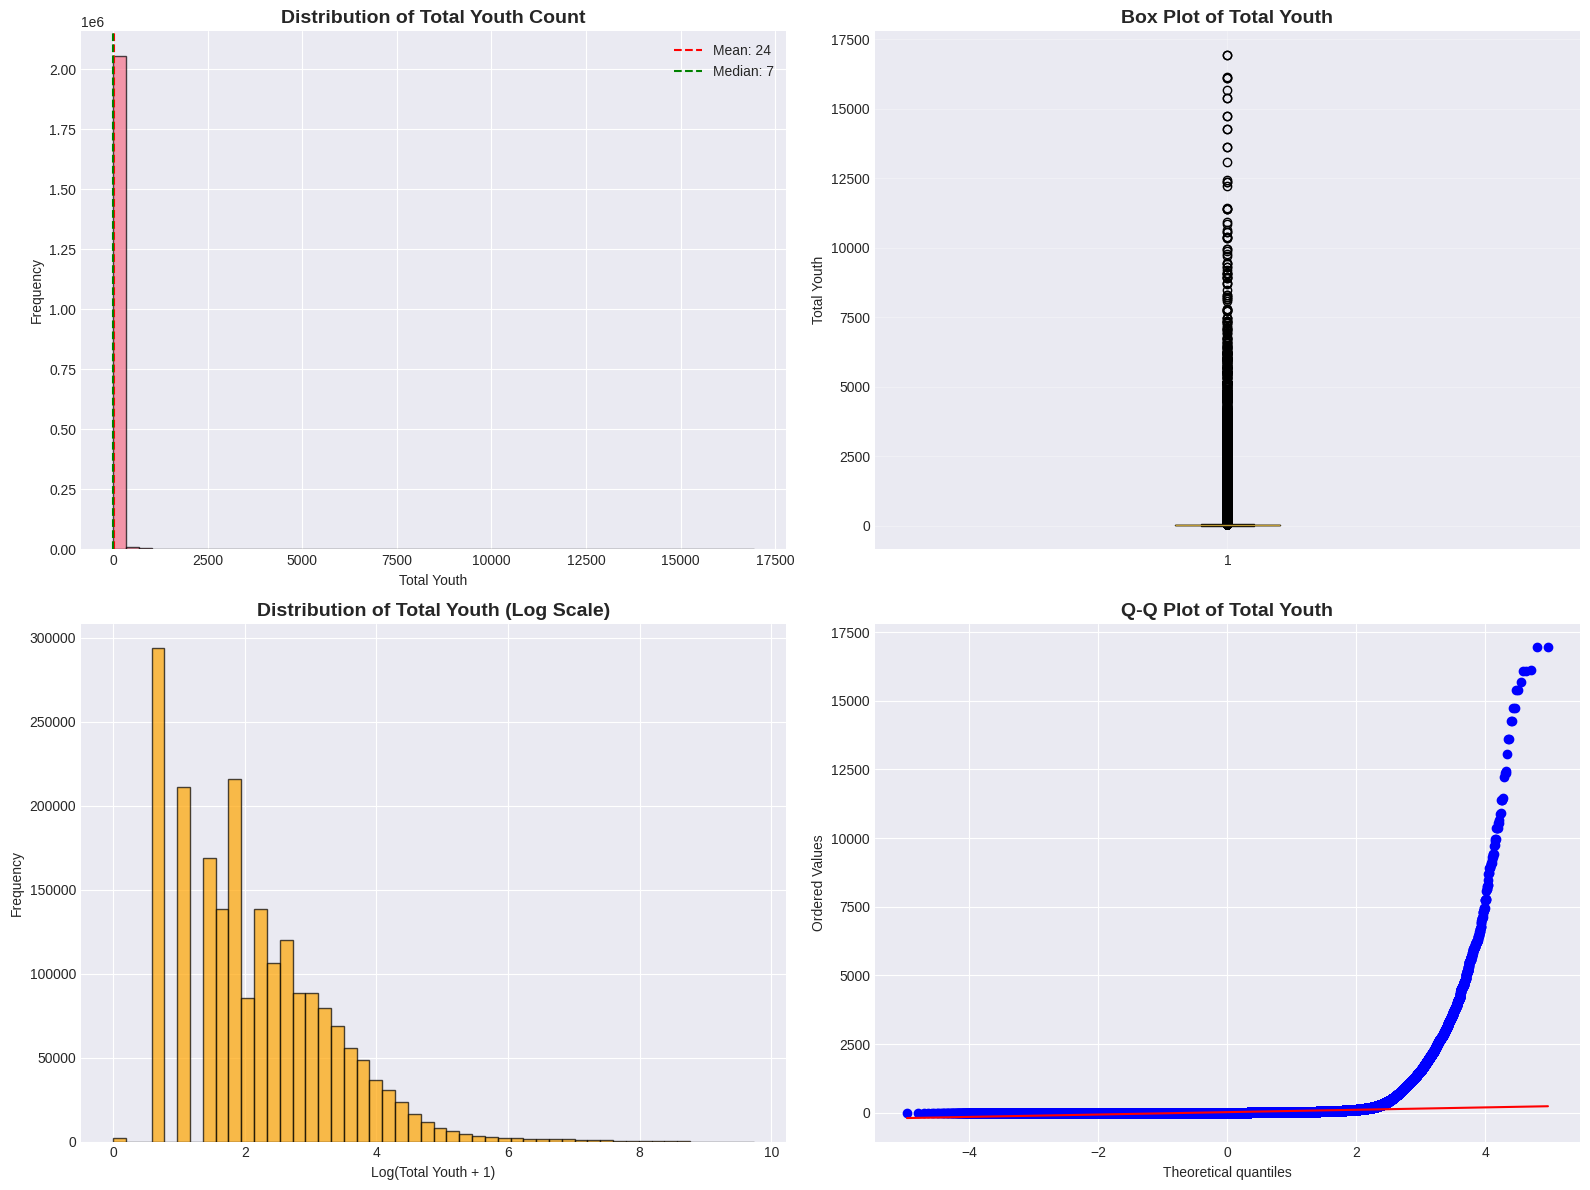

In [8]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Histogram
axes[0, 0].hist(combined_df['total_youth'].dropna(), bins=50, edgecolor='black', alpha=0.7)
axes[0, 0].set_title('Distribution of Total Youth Count', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Total Youth')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].axvline(combined_df['total_youth'].mean(), color='red',
                    linestyle='--', label=f'Mean: {combined_df["total_youth"].mean():.0f}')
axes[0, 0].axvline(combined_df['total_youth'].median(), color='green',
                    linestyle='--', label=f'Median: {combined_df["total_youth"].median():.0f}')
axes[0, 0].legend()

# Box plot
axes[0, 1].boxplot(combined_df['total_youth'].dropna(), vert=True)
axes[0, 1].set_title('Box Plot of Total Youth', fontsize=14, fontweight='bold')
axes[0, 1].set_ylabel('Total Youth')
axes[0, 1].grid(True, alpha=0.3)

# Log-scale histogram
axes[1, 0].hist(np.log1p(combined_df['total_youth'].dropna()), bins=50,
                edgecolor='black', alpha=0.7, color='orange')
axes[1, 0].set_title('Distribution of Total Youth (Log Scale)', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Log(Total Youth + 1)')
axes[1, 0].set_ylabel('Frequency')

# Q-Q Plot
stats.probplot(combined_df['total_youth'].dropna(), dist="norm", plot=axes[1, 1])
axes[1, 1].set_title('Q-Q Plot of Total Youth', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

### 3.2 Age Group Distributions

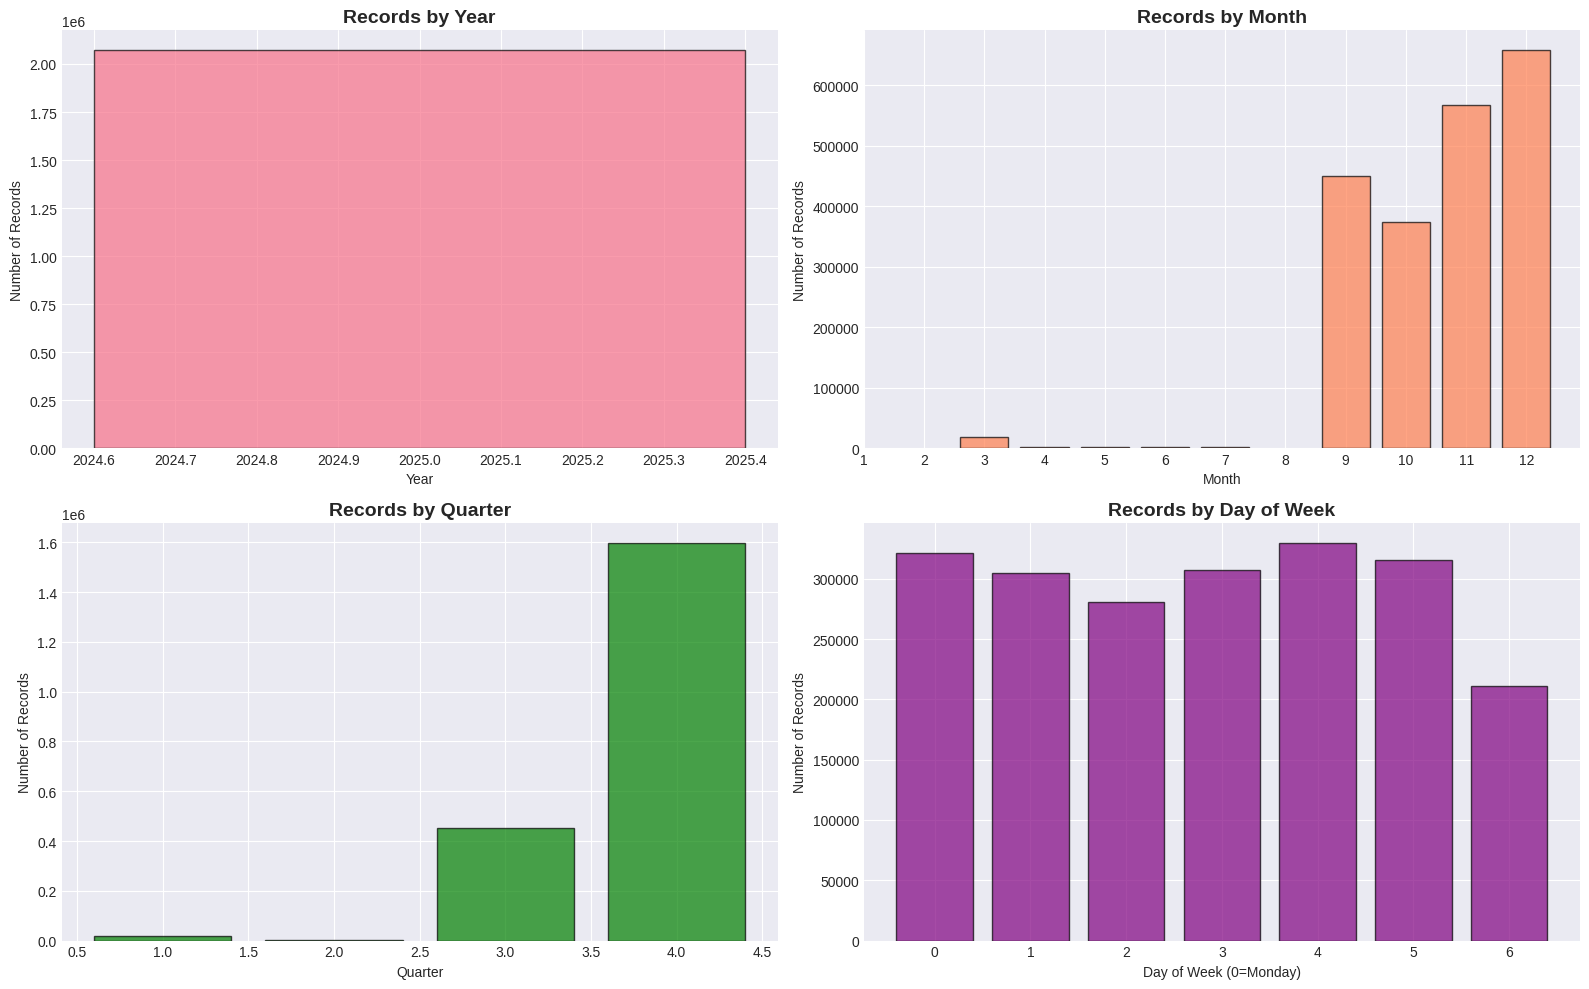

In [9]:
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Year distribution
year_counts = combined_df['year'].value_counts().sort_index()
axes[0, 0].bar(year_counts.index, year_counts.values, edgecolor='black', alpha=0.7)
axes[0, 0].set_title('Records by Year', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Year')
axes[0, 0].set_ylabel('Number of Records')

# Month distribution
month_counts = combined_df['month'].value_counts().sort_index()
axes[0, 1].bar(month_counts.index, month_counts.values, edgecolor='black', alpha=0.7, color='coral')
axes[0, 1].set_title('Records by Month', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Month')
axes[0, 1].set_ylabel('Number of Records')
axes[0, 1].set_xticks(range(1, 13))

# Quarter distribution
quarter_counts = combined_df['quarter'].value_counts().sort_index()
axes[1, 0].bar(quarter_counts.index, quarter_counts.values, edgecolor='black', alpha=0.7, color='green')
axes[1, 0].set_title('Records by Quarter', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Quarter')
axes[1, 0].set_ylabel('Number of Records')

# Day of week distribution
dow_counts = combined_df['day_of_week'].value_counts().sort_index()
axes[1, 1].bar(dow_counts.index, dow_counts.values, edgecolor='black', alpha=0.7, color='purple')
axes[1, 1].set_title('Records by Day of Week', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Day of Week (0=Monday)')
axes[1, 1].set_ylabel('Number of Records')

plt.tight_layout()
plt.show()

### 3.3 State-wise Distribution

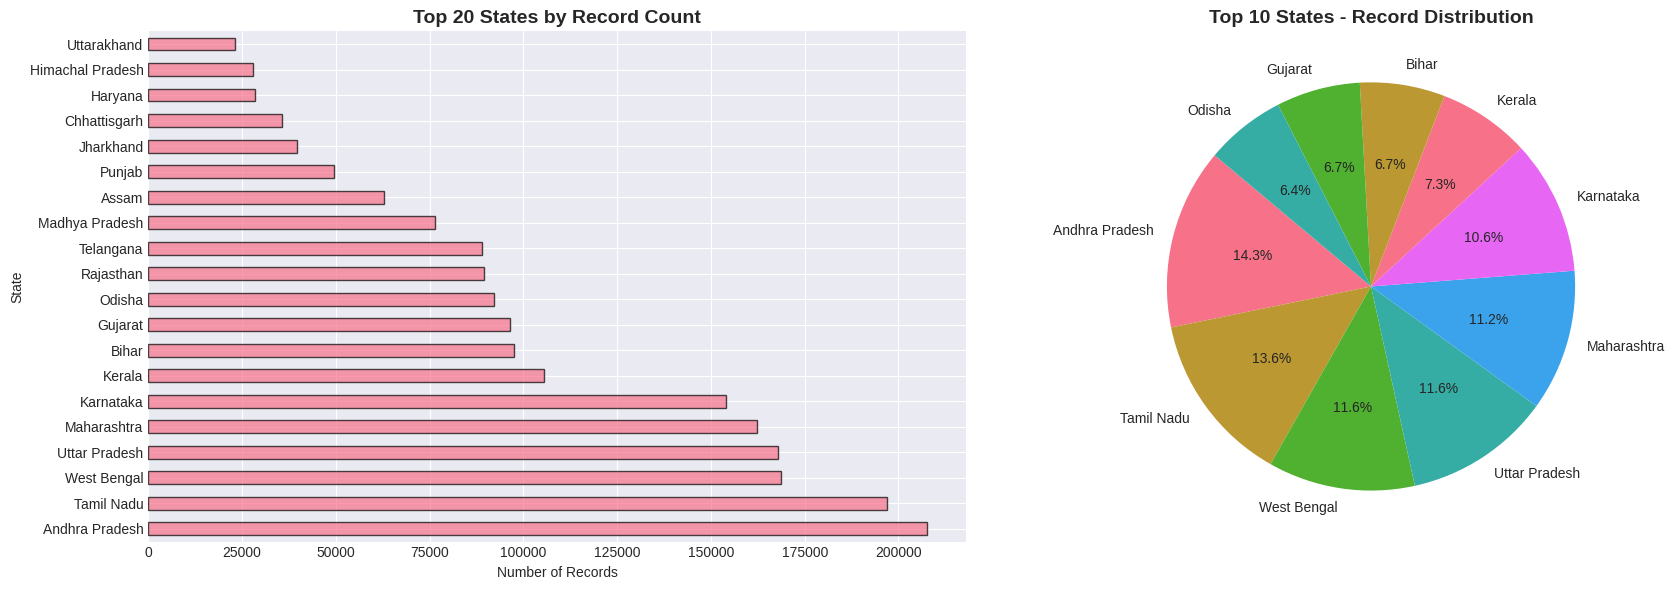

In [10]:
state_counts = combined_df['state'].value_counts().head(20)

fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Bar chart
state_counts.plot(kind='barh', ax=axes[0], edgecolor='black', alpha=0.7)
axes[0].set_title('Top 20 States by Record Count', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Number of Records')
axes[0].set_ylabel('State')

# Pie chart for top 10
top10_states = state_counts.head(10)
axes[1].pie(top10_states.values, labels=top10_states.index, autopct='%1.1f%%', startangle=140)
axes[1].set_title('Top 10 States - Record Distribution', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

## 4. BIVARIATE ANALYSIS

### 4.1 Youth vs Total Population

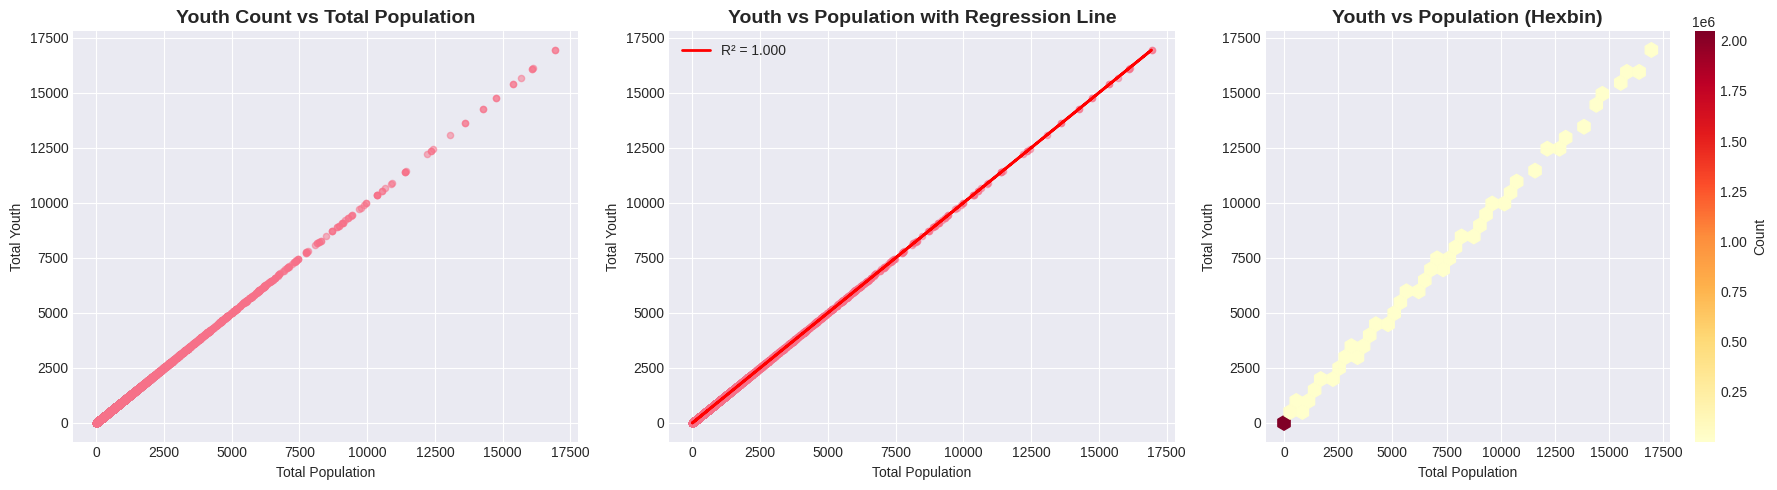

In [11]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Scatter plot
axes[0].scatter(combined_df['total_population'], combined_df['total_youth'],
                alpha=0.5, s=20)
axes[0].set_title('Youth Count vs Total Population', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Total Population')
axes[0].set_ylabel('Total Youth')

# Scatter with regression line
from scipy.stats import linregress
x = combined_df[['total_population', 'total_youth']].dropna()['total_population']
y = combined_df[['total_population', 'total_youth']].dropna()['total_youth']
slope, intercept, r_value, p_value, std_err = linregress(x, y)
axes[1].scatter(x, y, alpha=0.5, s=20)
axes[1].plot(x, slope * x + intercept, color='red', linewidth=2,
             label=f'R² = {r_value**2:.3f}')
axes[1].set_title('Youth vs Population with Regression Line', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Total Population')
axes[1].set_ylabel('Total Youth')
axes[1].legend()

# Hexbin plot
axes[2].hexbin(combined_df['total_population'], combined_df['total_youth'],
               gridsize=30, cmap='YlOrRd', mincnt=1)
axes[2].set_title('Youth vs Population (Hexbin)', fontsize=14, fontweight='bold')
axes[2].set_xlabel('Total Population')
axes[2].set_ylabel('Total Youth')
plt.colorbar(axes[2].collections[0], ax=axes[2], label='Count')

plt.tight_layout()
plt.show()

In [12]:
print(f"\nCorrelation between Total Population and Total Youth: {combined_df['total_population'].corr(combined_df['total_youth']):.3f}")


Correlation between Total Population and Total Youth: 1.000


### 4.2 Time Series Analysis

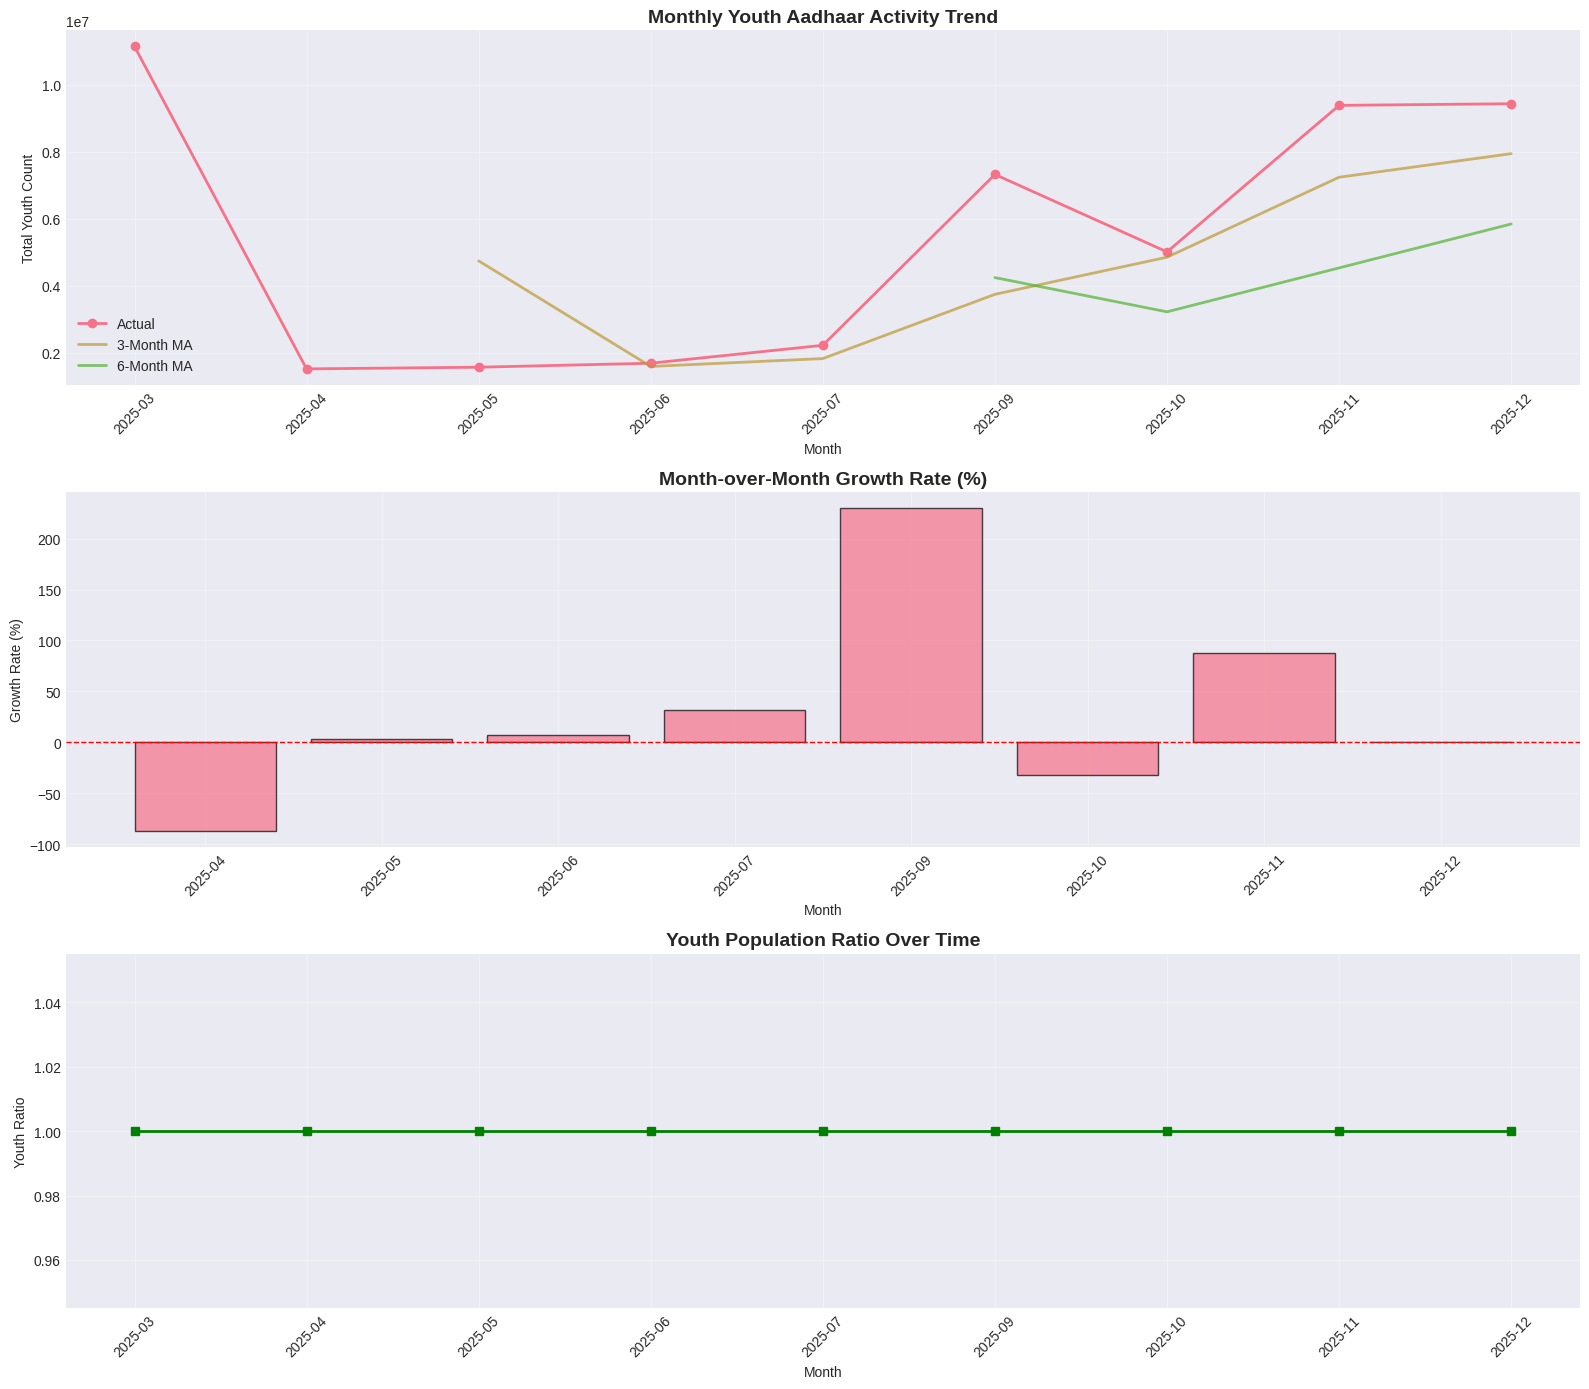

In [13]:
monthly_youth = combined_df.groupby('year_month').agg({
    'total_youth': 'sum',
    'total_population': 'sum',
    'youth_population_ratio': 'mean'
}).reset_index()

monthly_youth['year_month'] = monthly_youth['year_month'].astype(str)
monthly_youth['mom_growth'] = monthly_youth['total_youth'].pct_change() * 100
monthly_youth['rolling_3m'] = monthly_youth['total_youth'].rolling(3).mean()
monthly_youth['rolling_6m'] = monthly_youth['total_youth'].rolling(6).mean()

fig, axes = plt.subplots(3, 1, figsize=(16, 14))

# Total youth trend
axes[0].plot(monthly_youth['year_month'], monthly_youth['total_youth'],
             marker='o', linewidth=2, label='Actual')
axes[0].plot(monthly_youth['year_month'], monthly_youth['rolling_3m'],
             linewidth=2, label='3-Month MA', alpha=0.7)
axes[0].plot(monthly_youth['year_month'], monthly_youth['rolling_6m'],
             linewidth=2, label='6-Month MA', alpha=0.7)
axes[0].set_title('Monthly Youth Aadhaar Activity Trend', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Month')
axes[0].set_ylabel('Total Youth Count')
axes[0].legend()
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(True, alpha=0.3)

# Month-over-month growth
axes[1].bar(monthly_youth['year_month'], monthly_youth['mom_growth'],
            edgecolor='black', alpha=0.7)
axes[1].axhline(y=0, color='red', linestyle='--', linewidth=1)
axes[1].set_title('Month-over-Month Growth Rate (%)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Month')
axes[1].set_ylabel('Growth Rate (%)')
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(True, alpha=0.3)

# Youth ratio trend
axes[2].plot(monthly_youth['year_month'], monthly_youth['youth_population_ratio'],
             marker='s', color='green', linewidth=2)
axes[2].set_title('Youth Population Ratio Over Time', fontsize=14, fontweight='bold')
axes[2].set_xlabel('Month')
axes[2].set_ylabel('Youth Ratio')
axes[2].tick_params(axis='x', rotation=45)
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### 4.3 State-wise Analysis

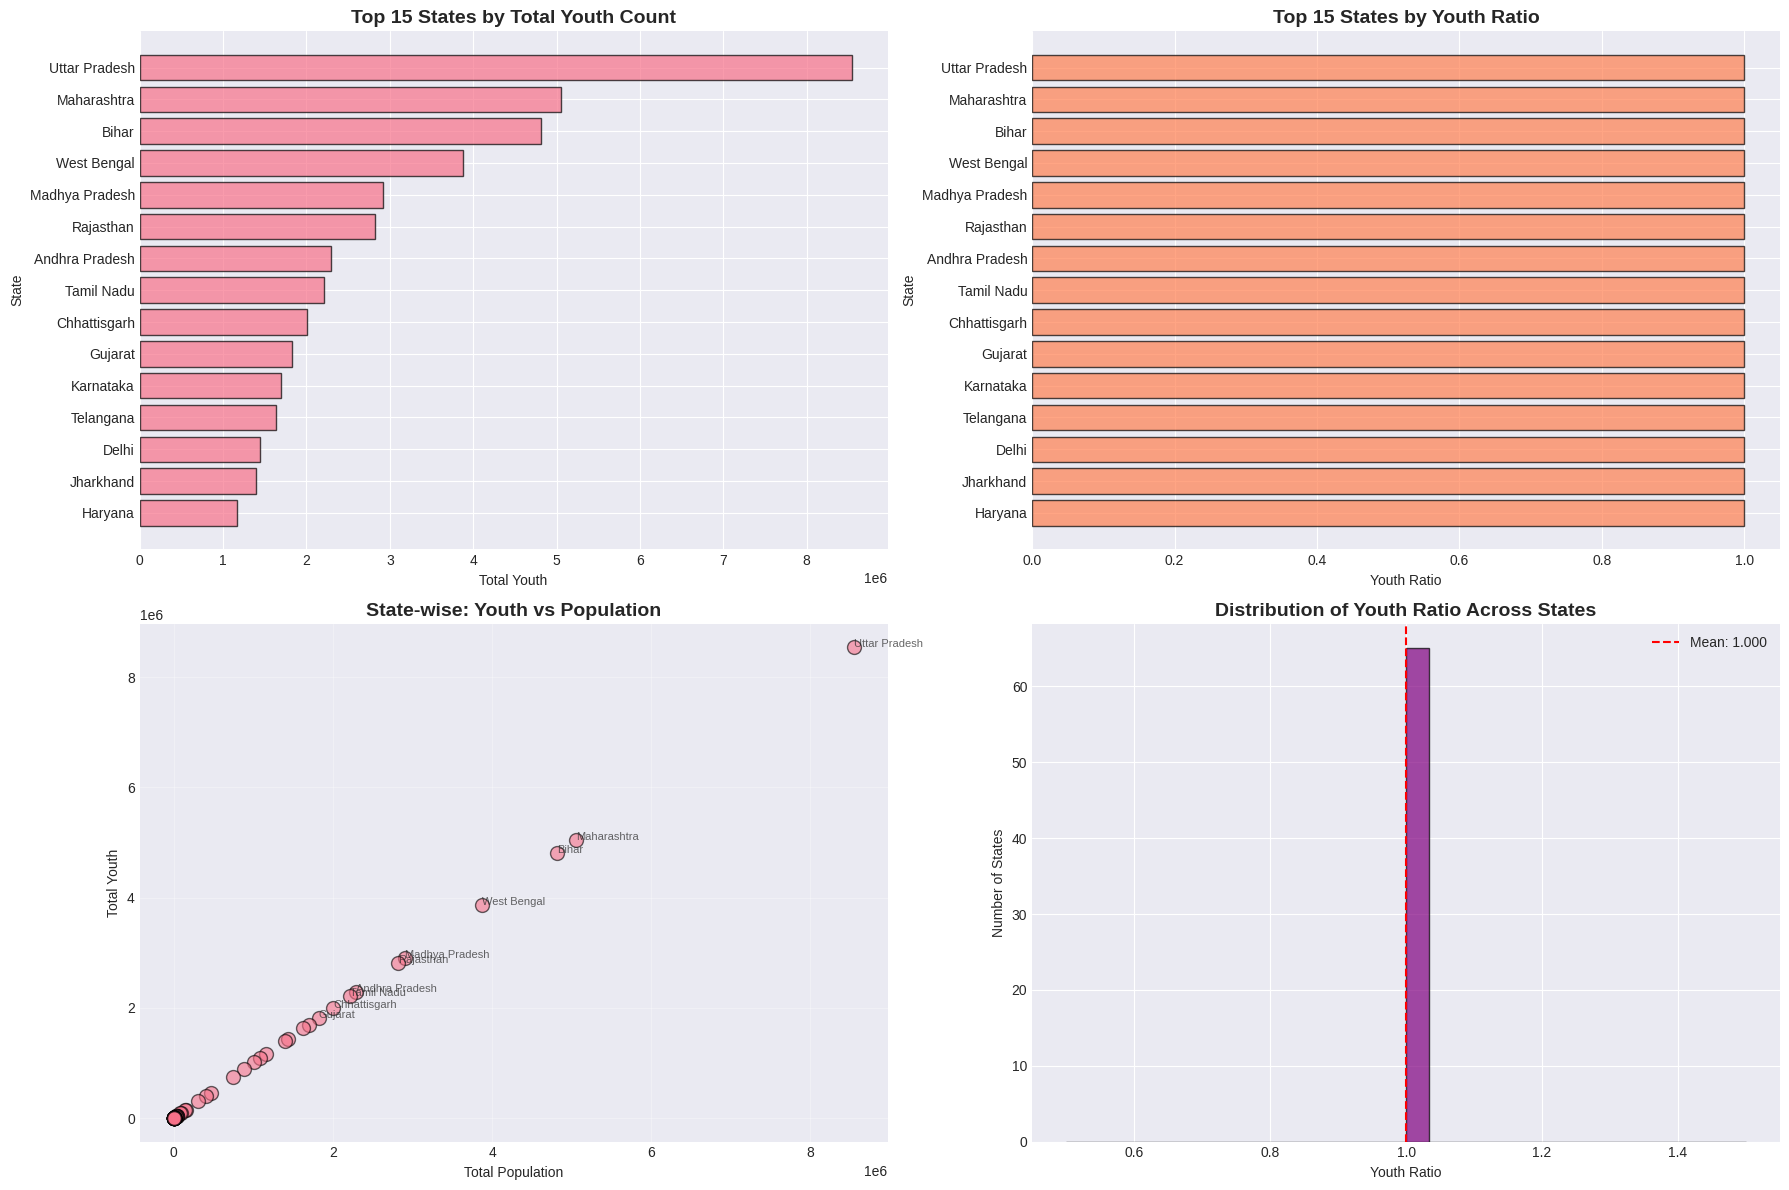

In [14]:
state_summary = combined_df.groupby('state').agg({
    'total_youth': 'sum',
    'total_population': 'sum',
    'youth_population_ratio': 'mean'
}).reset_index()

state_summary = state_summary.sort_values('total_youth', ascending=False)

fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# Top 15 states by youth count
top15_states = state_summary.head(15)
axes[0, 0].barh(top15_states['state'], top15_states['total_youth'], edgecolor='black', alpha=0.7)
axes[0, 0].set_title('Top 15 States by Total Youth Count', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Total Youth')
axes[0, 0].set_ylabel('State')
axes[0, 0].invert_yaxis()

# Top 15 states by youth ratio
top15_ratio = state_summary.sort_values('youth_population_ratio', ascending=False).head(15)
axes[0, 1].barh(top15_ratio['state'], top15_ratio['youth_population_ratio'],
                edgecolor='black', alpha=0.7, color='coral')
axes[0, 1].set_title('Top 15 States by Youth Ratio', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Youth Ratio')
axes[0, 1].set_ylabel('State')
axes[0, 1].invert_yaxis()

# Scatter: Youth vs Population by state
axes[1, 0].scatter(state_summary['total_population'], state_summary['total_youth'],
                   s=100, alpha=0.6, edgecolors='black')
for idx, row in state_summary.head(10).iterrows():
    axes[1, 0].annotate(row['state'], (row['total_population'], row['total_youth']),
                        fontsize=8, alpha=0.7)
axes[1, 0].set_title('State-wise: Youth vs Population', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Total Population')
axes[1, 0].set_ylabel('Total Youth')
axes[1, 0].grid(True, alpha=0.3)

# Youth ratio distribution by state
axes[1, 1].hist(state_summary['youth_population_ratio'], bins=30,
                edgecolor='black', alpha=0.7, color='purple')
axes[1, 1].set_title('Distribution of Youth Ratio Across States', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Youth Ratio')
axes[1, 1].set_ylabel('Number of States')
axes[1, 1].axvline(state_summary['youth_population_ratio'].mean(), color='red',
                   linestyle='--', label=f'Mean: {state_summary["youth_population_ratio"].mean():.3f}')
axes[1, 1].legend()

plt.tight_layout()
plt.show()

### 4.4 Heatmap - Top States Monthly Activity

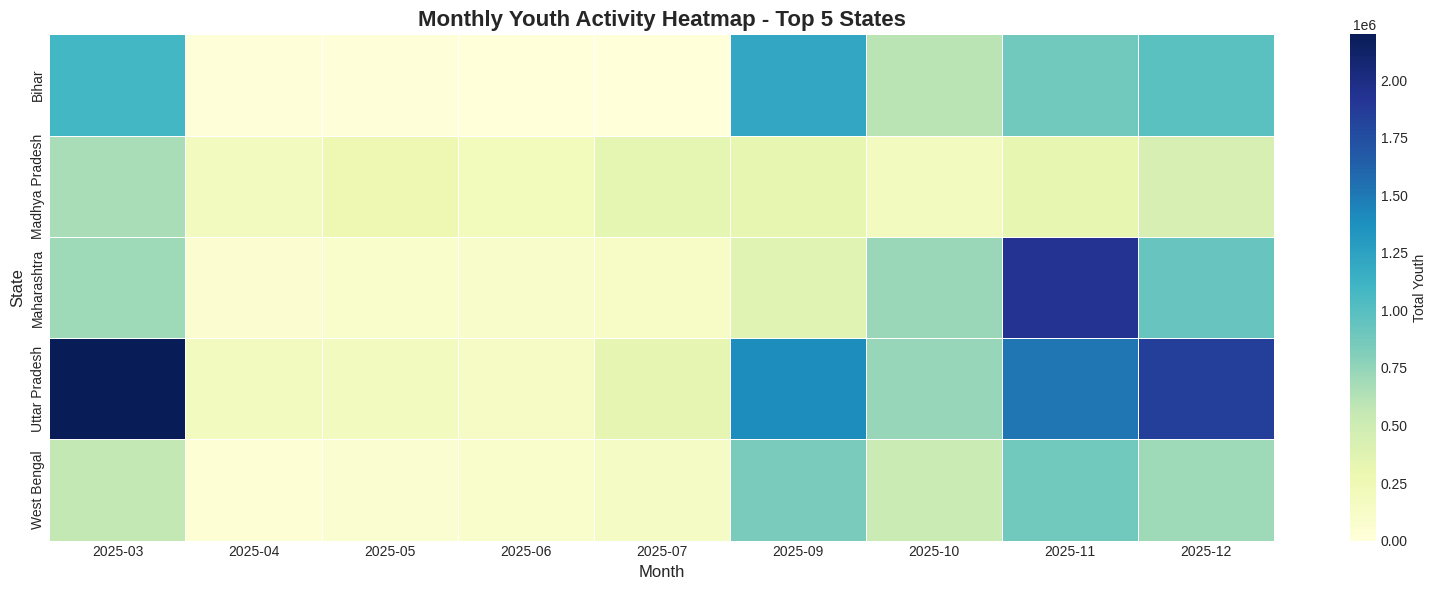

In [15]:
top5_states = state_summary.head(5)['state'].tolist()
state_monthly = combined_df[combined_df['state'].isin(top5_states)].groupby(
    ['state', 'year_month']
)['total_youth'].sum().unstack(fill_value=0)

state_monthly.columns = state_monthly.columns.astype(str)

plt.figure(figsize=(16, 6))
sns.heatmap(state_monthly, cmap='YlGnBu', annot=False, fmt='.0f',
            linewidths=0.5, cbar_kws={'label': 'Total Youth'})
plt.title('Monthly Youth Activity Heatmap - Top 5 States', fontsize=16, fontweight='bold')
plt.xlabel('Month', fontsize=12)
plt.ylabel('State', fontsize=12)
plt.tight_layout()
plt.show()

### 4.5 Correlation Analysis

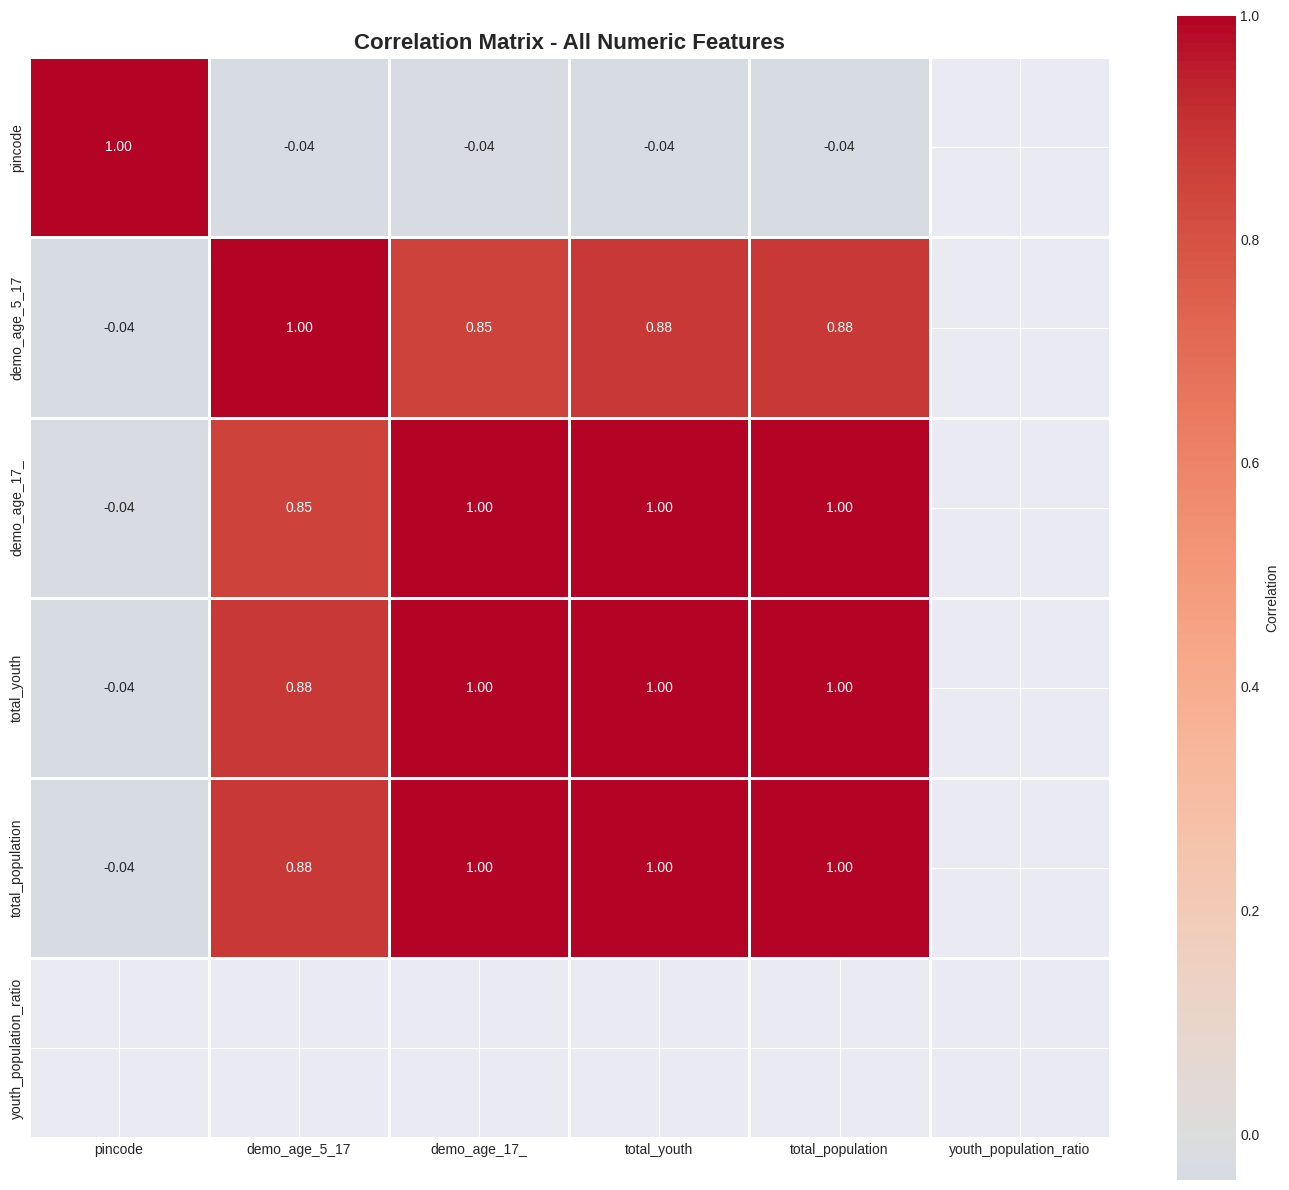

In [16]:
# Select numeric columns
numeric_cols = combined_df.select_dtypes(include=[np.number]).columns.tolist()
numeric_cols = [col for col in numeric_cols if col not in ['year', 'month', 'quarter',
                                                             'day_of_week', 'is_weekend']]

corr_matrix = combined_df[numeric_cols].corr()

plt.figure(figsize=(14, 12))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0,
            square=True, linewidths=1, cbar_kws={'label': 'Correlation'})
plt.title('Correlation Matrix - All Numeric Features', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

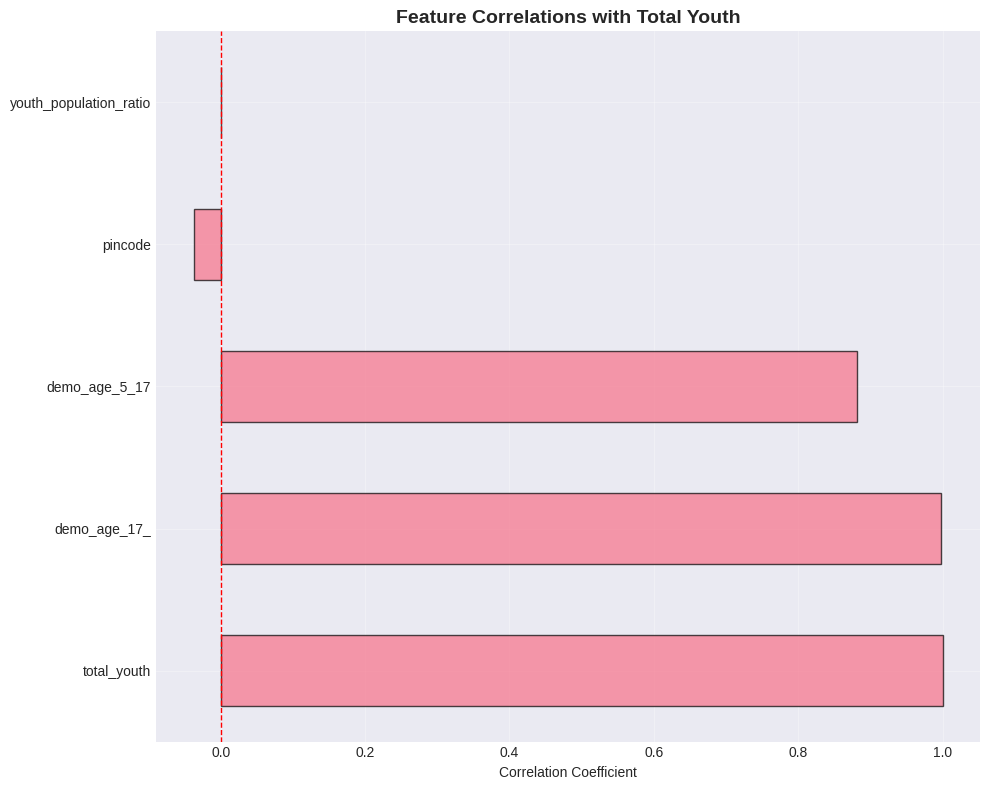

In [17]:
# Focus on youth-related correlations
youth_corr = corr_matrix['total_youth'].sort_values(ascending=False)

plt.figure(figsize=(10, 8))
youth_corr[1:].plot(kind='barh', edgecolor='black', alpha=0.7)
plt.title('Feature Correlations with Total Youth', fontsize=14, fontweight='bold')
plt.xlabel('Correlation Coefficient')
plt.axvline(x=0, color='red', linestyle='--', linewidth=1)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### 4.6 Box Plots - Youth by Categorical Variables

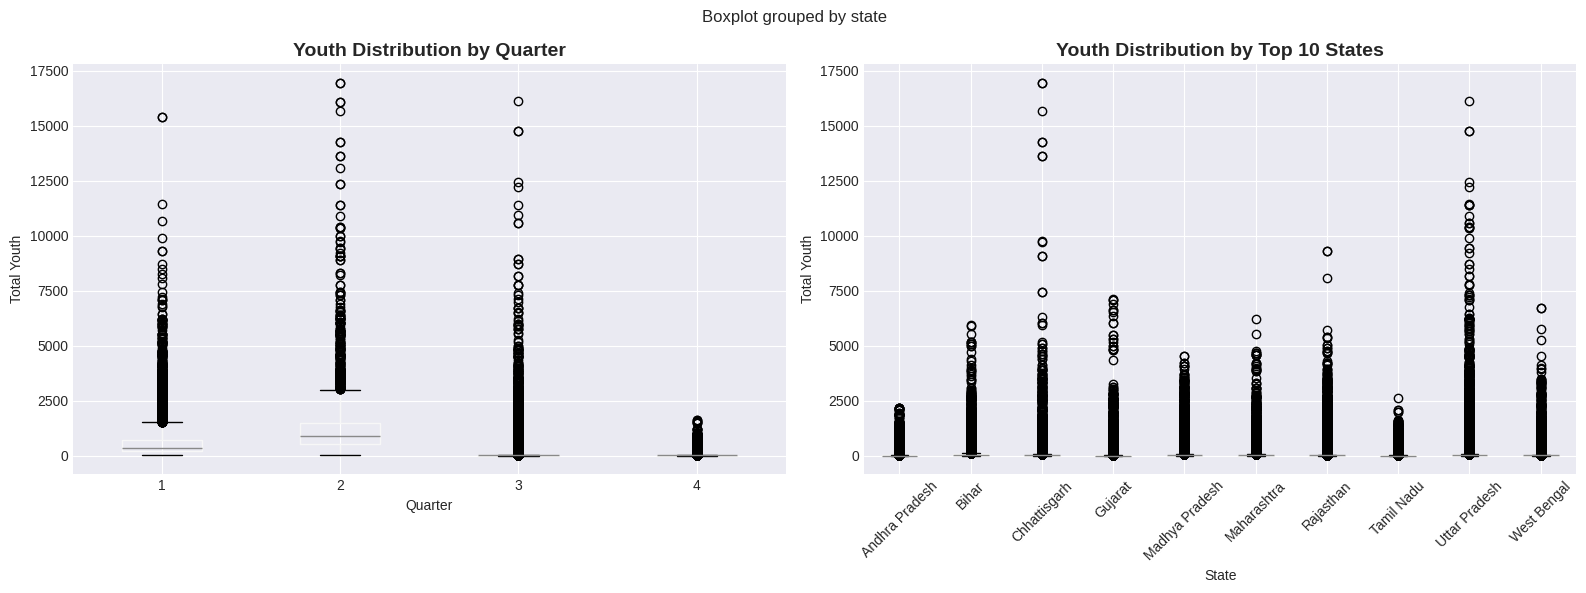

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Youth by quarter
combined_df.boxplot(column='total_youth', by='quarter', ax=axes[0])
axes[0].set_title('Youth Distribution by Quarter', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Quarter')
axes[0].set_ylabel('Total Youth')
plt.sca(axes[0])
plt.xticks([1, 2, 3, 4])

# Youth by top 10 states
top10_states_list = state_summary.head(10)['state'].tolist()
combined_df[combined_df['state'].isin(top10_states_list)].boxplot(
    column='total_youth', by='state', ax=axes[1], rot=45
)
axes[1].set_title('Youth Distribution by Top 10 States', fontsize=14, fontweight='bold')
axes[1].set_xlabel('State')
axes[1].set_ylabel('Total Youth')

plt.tight_layout()
plt.show()

## 5. ADVANCED FEATURE ENGINEERING

In [19]:
# Sort data
combined_df = combined_df.sort_values(['state', 'date'])

In [20]:
# Lag features
combined_df['youth_lag_1m'] = combined_df.groupby('state')['total_youth'].shift(1)
combined_df['youth_lag_3m'] = combined_df.groupby('state')['total_youth'].shift(3)
combined_df['youth_lag_6m'] = combined_df.groupby('state')['total_youth'].shift(6)

In [21]:
# Growth rates
combined_df['youth_growth_1m'] = ((combined_df['total_youth'] - combined_df['youth_lag_1m']) /
                                   combined_df['youth_lag_1m']) * 100
combined_df['youth_growth_3m'] = ((combined_df['total_youth'] - combined_df['youth_lag_3m']) /
                                   combined_df['youth_lag_3m']) * 100

In [22]:
# Rolling statistics
combined_df['youth_volatility_3m'] = combined_df.groupby('state')['total_youth'].transform(
    lambda x: x.rolling(3).std()
)
combined_df['youth_volatility_6m'] = combined_df.groupby('state')['total_youth'].transform(
    lambda x: x.rolling(6).std()
)

combined_df['youth_mean_3m'] = combined_df.groupby('state')['total_youth'].transform(
    lambda x: x.rolling(3).mean()
)


In [23]:
# Replace infinities
combined_df.replace([np.inf, -np.inf], np.nan, inplace=True)

print("New features created:")
print(['youth_lag_1m', 'youth_lag_3m', 'youth_growth_1m', 'youth_growth_3m',
       'youth_volatility_3m', 'youth_mean_3m'])

New features created:
['youth_lag_1m', 'youth_lag_3m', 'youth_growth_1m', 'youth_growth_3m', 'youth_volatility_3m', 'youth_mean_3m']


## 6. CLUSTERING ANALYSIS

In [24]:
# Prepare ML dataset
ml_df = combined_df[[
    'state', 'total_youth', 'youth_growth_1m', 'youth_volatility_3m',
    'youth_population_ratio'
]].dropna()

state_ml = ml_df.groupby('state').agg({
    'total_youth': 'mean',
    'youth_growth_1m': 'mean',
    'youth_volatility_3m': 'mean',
    'youth_population_ratio': 'mean'
}).reset_index()

In [25]:
# Standardize features
X = state_ml.drop('state', axis=1)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

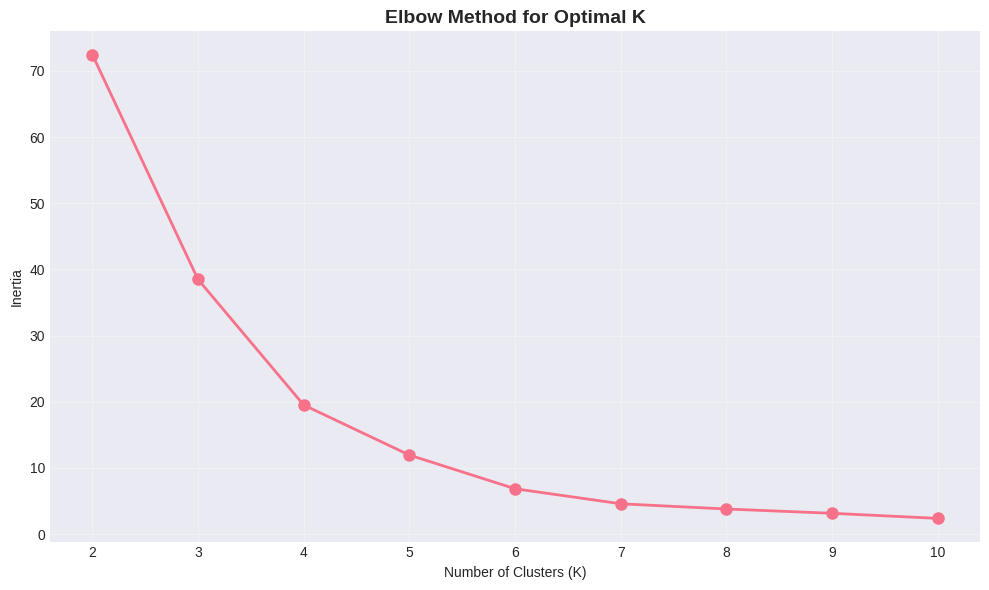

In [26]:
# Elbow method
inertias = []
K_range = range(2, 11)
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(K_range, inertias, marker='o', linewidth=2, markersize=8)
plt.title('Elbow Method for Optimal K', fontsize=14, fontweight='bold')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [27]:
# Apply K-Means with optimal clusters
n_clusters = 3
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
state_ml['cluster'] = kmeans.fit_predict(X_scaled)

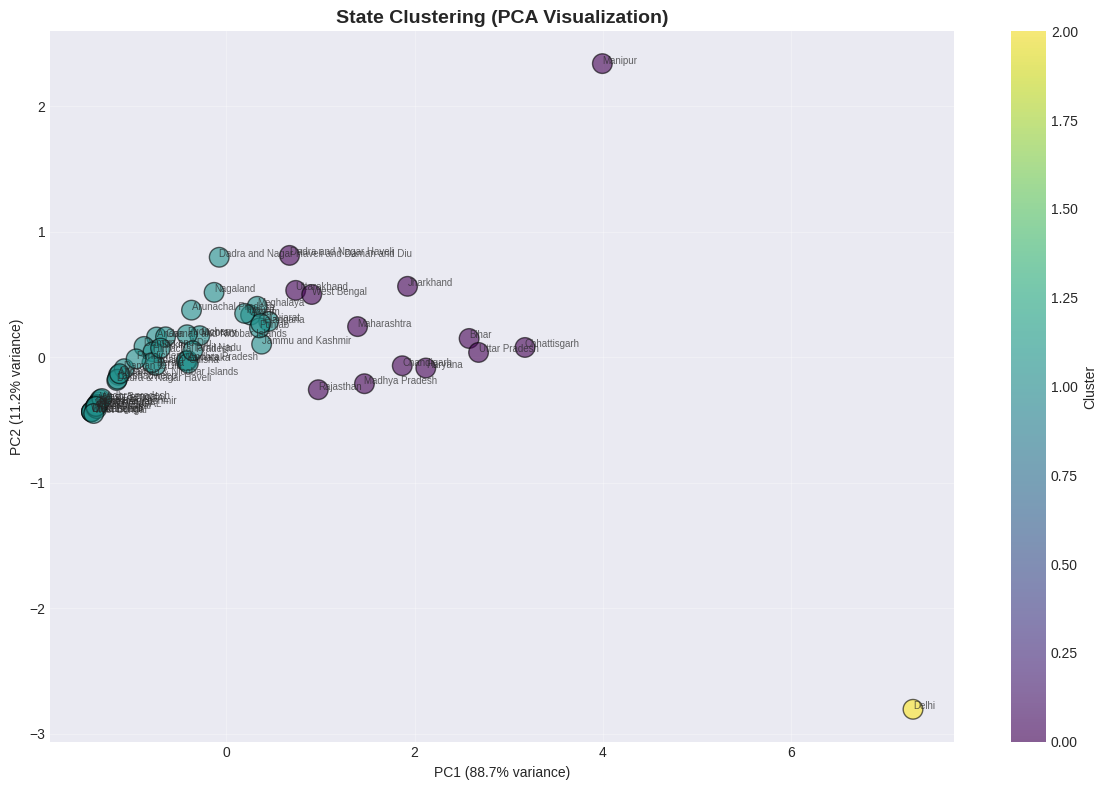

In [28]:
# PCA for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(12, 8))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=state_ml['cluster'],
                      s=200, alpha=0.6, edgecolors='black', cmap='viridis')
plt.colorbar(scatter, label='Cluster')
plt.title('State Clustering (PCA Visualization)', fontsize=14, fontweight='bold')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% variance)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% variance)')

# Annotate states
for idx, row in state_ml.iterrows():
    plt.annotate(row['state'], (X_pca[idx, 0], X_pca[idx, 1]),
                 fontsize=7, alpha=0.7)

plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [29]:
# Cluster summary
cluster_summary = state_ml.groupby('cluster').agg({
    'total_youth': ['mean', 'std', 'count'],
    'youth_growth_1m': ['mean', 'std'],
    'youth_volatility_3m': ['mean', 'std'],
    'youth_population_ratio': ['mean', 'std']
})

print("\n" + "="*80)
print("CLUSTER SUMMARY STATISTICS")
print("="*80)
print(cluster_summary)


CLUSTER SUMMARY STATISTICS
        total_youth                  youth_growth_1m              \
               mean        std count            mean         std   
cluster                                                            
0         36.422815  12.238264    13      270.305847  102.454619   
1          6.563116   5.987592    43       77.691465   63.943313   
2        136.270897        NaN     1      296.505217         NaN   

        youth_volatility_3m           youth_population_ratio       
                       mean       std                   mean  std  
cluster                                                            
0                 28.272263  9.240437                    1.0  0.0  
1                  4.445770  4.608827                    1.0  0.0  
2                 97.805317       NaN                    1.0  NaN  


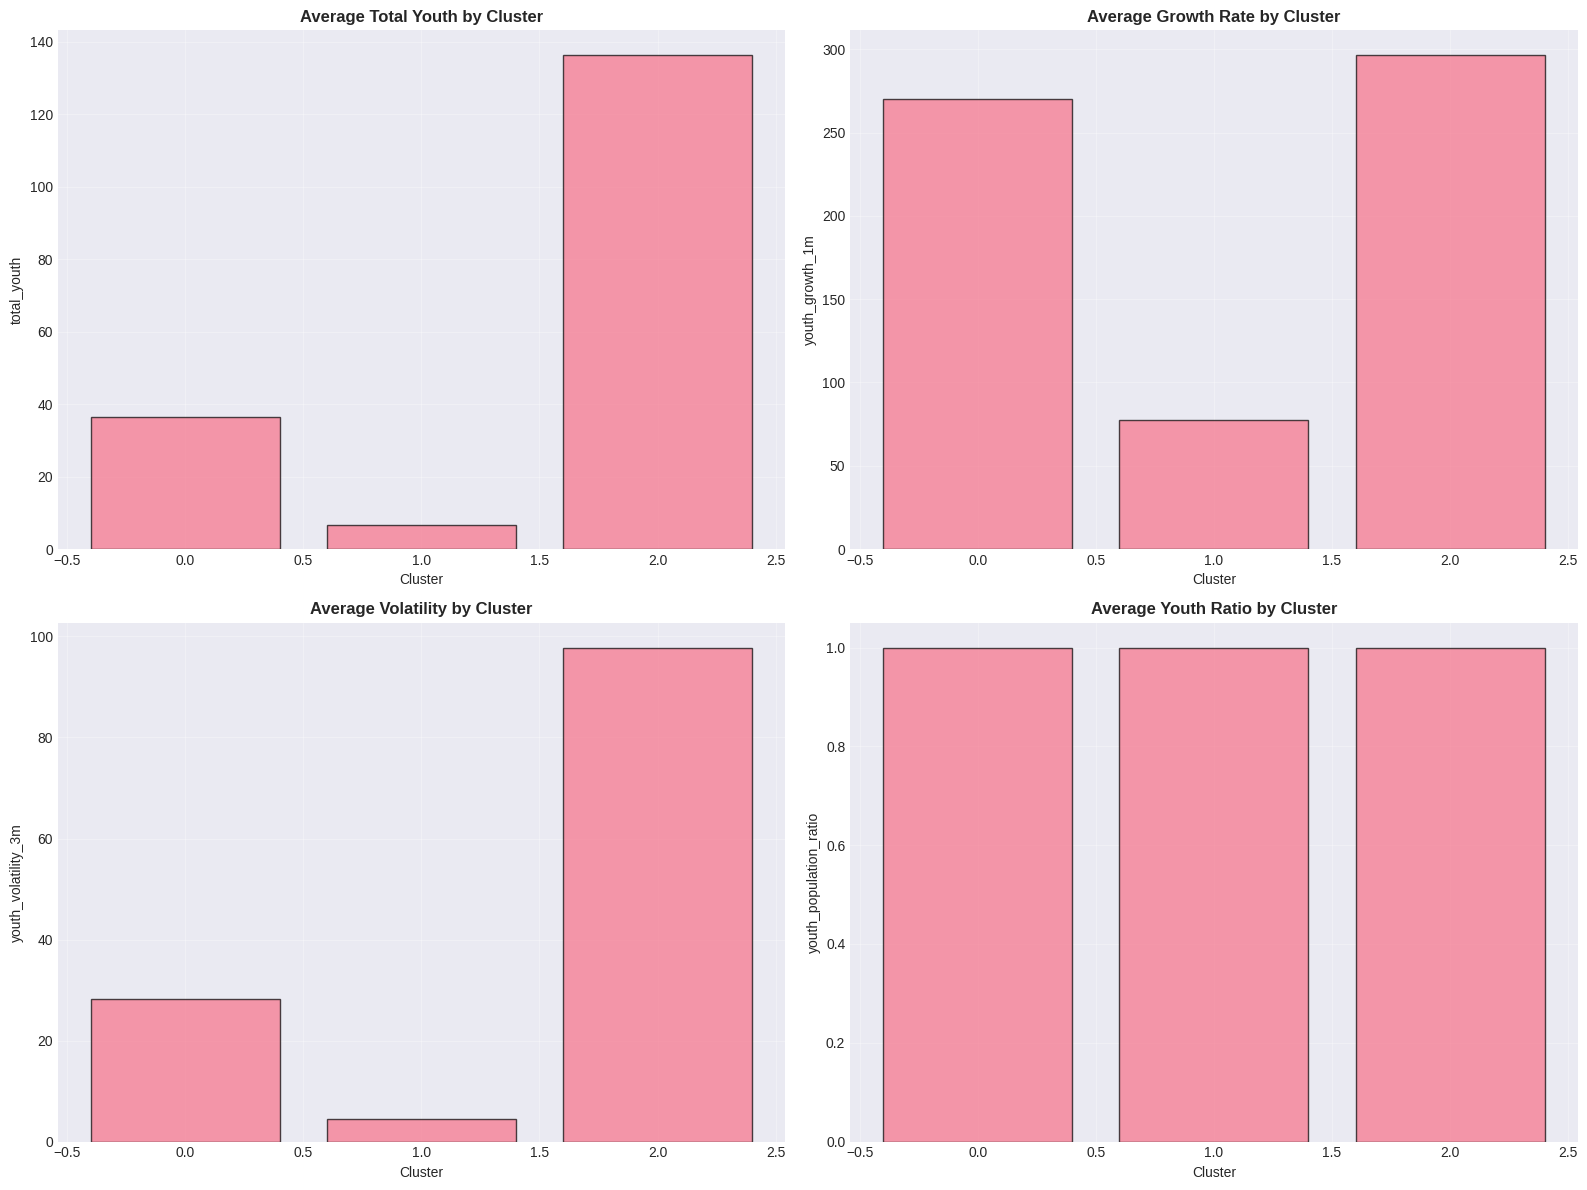

In [30]:
# Cluster characteristics
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

features = ['total_youth', 'youth_growth_1m', 'youth_volatility_3m', 'youth_population_ratio']
titles = ['Average Total Youth', 'Average Growth Rate', 'Average Volatility', 'Average Youth Ratio']

for idx, (feature, title) in enumerate(zip(features, titles)):
    ax = axes[idx // 2, idx % 2]
    cluster_means = state_ml.groupby('cluster')[feature].mean()
    ax.bar(cluster_means.index, cluster_means.values, edgecolor='black', alpha=0.7)
    ax.set_title(f'{title} by Cluster', fontsize=12, fontweight='bold')
    ax.set_xlabel('Cluster')
    ax.set_ylabel(feature)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [31]:
# States in each cluster
print("\n" + "="*80)
print("STATES BY CLUSTER")
print("="*80)
for cluster_id in sorted(state_ml['cluster'].unique()):
    states_in_cluster = state_ml[state_ml['cluster'] == cluster_id]['state'].tolist()
    print(f"\nCluster {cluster_id} ({len(states_in_cluster)} states):")
    print(", ".join(states_in_cluster))


STATES BY CLUSTER

Cluster 0 (13 states):
Bihar, Chandigarh, Chhattisgarh, Dadra and Nagar Haveli, Haryana, Jharkhand, Madhya Pradesh, Maharashtra, Manipur, Rajasthan, Uttar Pradesh, Uttarakhand, West Bengal

Cluster 1 (43 states):
Andaman & Nicobar Islands, Andaman and Nicobar Islands, Andhra Pradesh, Arunachal Pradesh, Assam, Chhatisgarh, Dadra & Nagar Haveli, Dadra and Nagar Haveli and Daman and Diu, Daman & Diu, Daman and Diu, Goa, Gujarat, Himachal Pradesh, Jammu & Kashmir, Jammu and Kashmir, Karnataka, Kerala, Ladakh, Lakshadweep, Meghalaya, Mizoram, Nagaland, ODISHA, Odisha, Orissa, Pondicherry, Puducherry, Punjab, Sikkim, Tamil Nadu, Telangana, Tripura, Uttaranchal, WEST BENGAL, WESTBENGAL, West  Bengal, West Bangal, West Bengli, West bengal, Westbengal, andhra pradesh, odisha, west Bengal

Cluster 2 (1 states):
Delhi


## 7. FINAL SUMMARY

In [33]:
summary_stats = {
    'Total Records': combined_df.shape[0],
    'Total States': combined_df['state'].nunique(),
    'Date Range': f"{combined_df['date'].min()} to {combined_df['date'].max()}",
    'Total Youth (Sum)': combined_df['total_youth'].sum(),
    'Average Youth per Record': combined_df['total_youth'].mean(),
    'Average Youth Ratio': combined_df['youth_population_ratio'].mean(),
    'Number of Clusters': n_clusters
}

for key, value in summary_stats.items():
    print(f"{key}: {value}")

Total Records: 2071700
Total States: 65
Date Range: 2025-03-01 00:00:00 to 2025-12-29 00:00:00
Total Youth (Sum): 49295187
Average Youth per Record: 23.794558575083265
Average Youth Ratio: 1.0
Number of Clusters: 3
